In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view
from arch import arch_model
from scipy.stats import chi2
from scipy.stats import norm
import seaborn as sns

### Initialisation

In [4]:
### Initialisation
df = pd.read_csv('../data/QRM-2025-cw1-data-b.csv')
prices = df['Adj Close'].values
dates = pd.to_datetime(df['Date'], dayfirst=True).values[1:]
losses = -np.log(prices[1:] / prices[:-1])
T = len(losses)

### Common HS Setup
N = 500 # Window Size
targets = losses[N:]
target_dates = dates[N:]

### Part (i): Historical Simulation (HS)

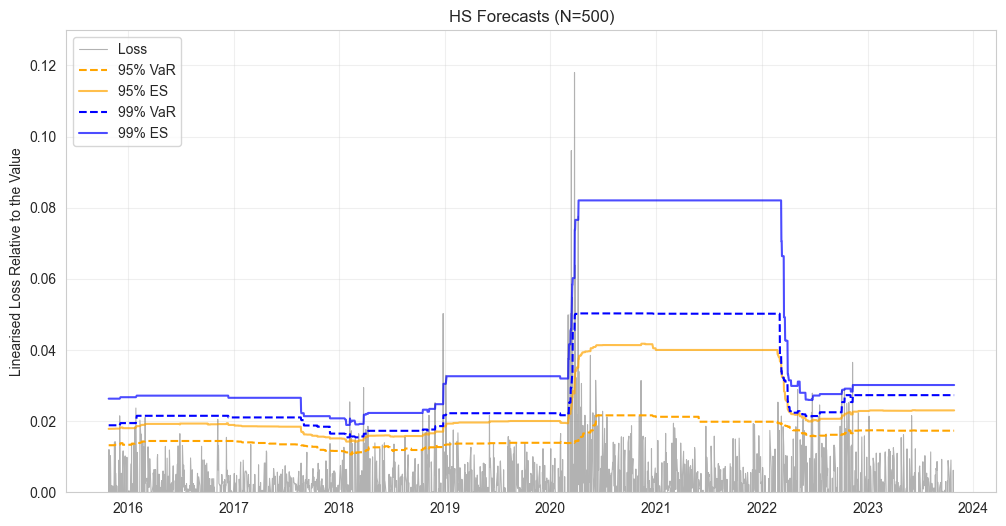

In [5]:
### Part (i)
windows = sliding_window_view(losses[:-1], window_shape=N) # Technical reason to exclude the last date
var_95_i = np.quantile(windows, 0.95, axis=1)
es_95_i = np.array([w[w >= v].mean() for w, v in zip(windows, var_95_i)])

var_99_i = np.quantile(windows, 0.99, axis=1)
es_99_i = np.array([w[w >= v].mean() for w, v in zip(windows, var_99_i)])


plt.figure(figsize=(12, 6))
plt.plot(target_dates, targets, 'gray', alpha=0.6, lw=0.8, label='Loss')
plt.plot(target_dates, var_95_i, 'orange', linestyle='--', label='95% VaR')
plt.plot(target_dates, es_95_i, 'orange', alpha=0.7, label='95% ES')
plt.plot(target_dates, var_99_i, 'blue', linestyle='--', label='99% VaR')
plt.plot(target_dates, es_99_i, 'blue', alpha=0.7, label='99% ES')
plt.ylim(bottom=0) # Only include positive losses
plt.title(f'HS Forecasts (N={N})')
plt.ylabel('Linearised Loss Relative to the Value')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.savefig('assets/hs.png')
plt.show()

Overall, VaR/ES forecasts based on the HS method adjust to changes in market volatility: they rise during periods of high volatility and decline during periods of stability, capturing the temporal variability of risk.

However, due to the use of a 500-day window, HS forecasts exhibit significant smoothing:

- After volatility decreases, VaR/ES levels remain high as long as the window still contains many extreme observations.

This indicates that the HS method is essentially "completely backward-looking."

### Part (ii): Filtered historical simulation (FHS) with exponentially-weighted moving average (EWMA)

The EWMA volatility forecast is computed recursively by
$$
\hat{\sigma}^2_{t+1} = \alpha(X_t - \hat{\mu}_t)^2 + (1 - \alpha)\hat{\sigma}^2_{t}
$$
We were asked to take $\alpha = 0.06$ and $\hat{\mu}_t = 0 \;\;\forall t$.

We choose the initial volatility value $\hat{\sigma}_0$ to be the sample variance of the log return of the first 500 days.

To compute the VaR and ES forecasts, use the formula from lecture:
$$
\hat{\text{VaR}}_{\alpha}(L_{t+1}) = \hat{\mu}_{t+1} + \hat{\sigma}_{t+1}q_\alpha(Z_{t+1})
$$
$$
\hat{\text{ES}}_{\alpha}(L_{t+1}) = \hat{\mu}_{t+1} + \hat{\sigma}_{t+1}\hat{\text{ES}}_\alpha(Z_{t+1})
$$

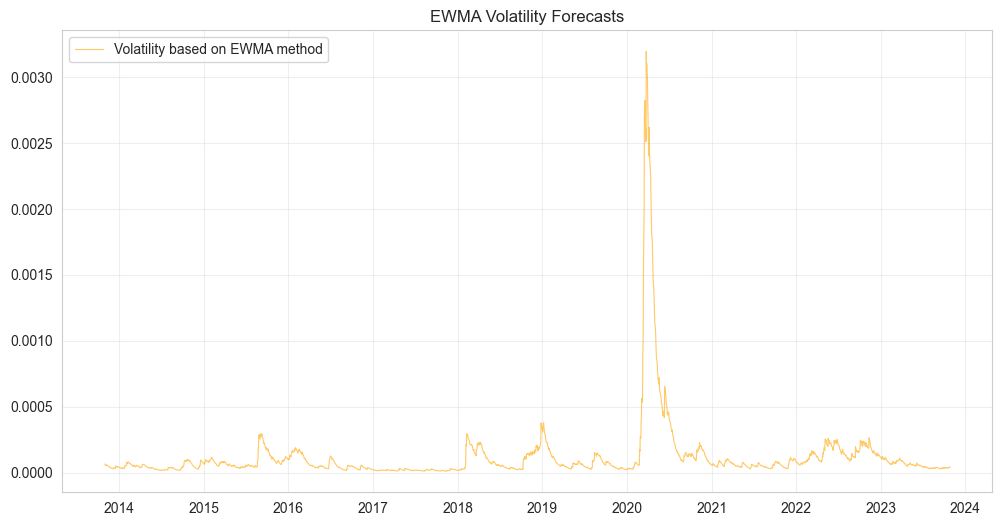

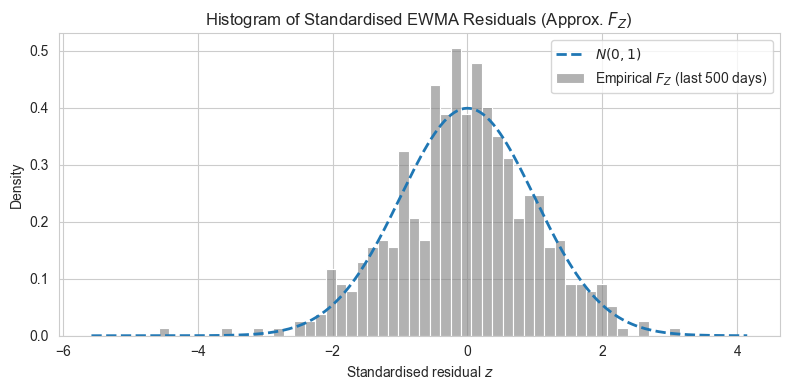

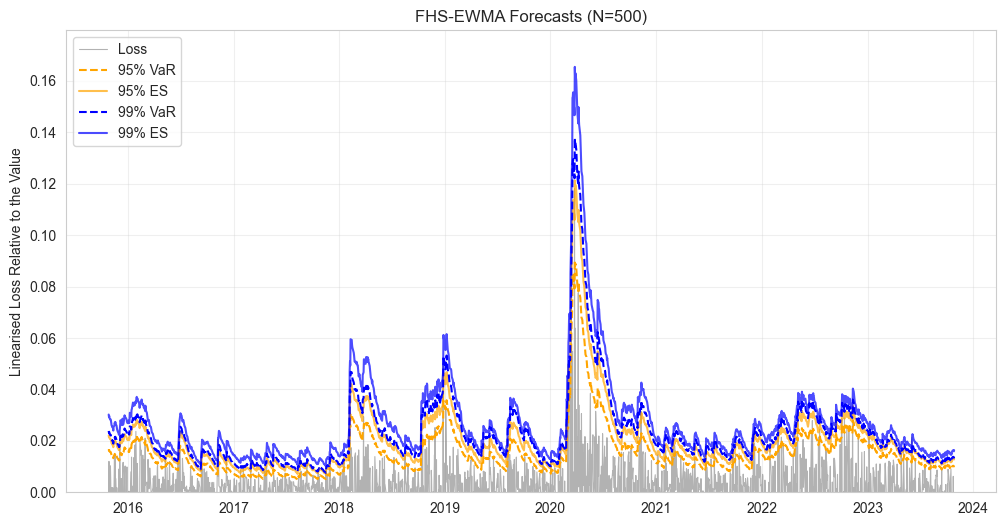

In [6]:
### Part (ii)
sigma2 = np.zeros(T)
sigma2[0] = np.var(losses[:N]) # Take variance as initial condition (DUE TO DISCUSS）

# Run EWMA
for t in range(1, T):
    sigma2[t] = (1 - 0.06) * sigma2[t-1] + 0.06 * losses[t-1]**2
sigma = np.sqrt(sigma2)
plt.figure(figsize=(12, 6))
plt.plot(dates, sigma2, 'orange', alpha=0.6, lw=0.8, label='Volatility based on EWMA method')
plt.title('EWMA Volatility Forecasts')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.savefig('assets/ewma_vol.png')
plt.show()

std_residuals = losses / sigma # Assume mean is zero (DUE TO DISCUSS)
z_window = std_residuals[-500:]

plt.figure(figsize=(8, 4))
ax = sns.histplot(data = z_window, bins=50, stat = "density", color = 'gray', alpha = 0.6, label='Empirical $F_Z$ (last 500 days)')
xs = np.linspace(z_window.min() - 1, z_window.max() + 1, 200)
plt.plot(xs, norm.pdf(xs), linewidth=2, linestyle = '--',
         label='$N(0,1)$')
plt.title('Histogram of Standardised EWMA Residuals (Approx. $F_Z$)')
plt.xlabel('Standardised residual $z$')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

windows = sliding_window_view(std_residuals[:-1], window_shape=N)
vols = sigma[N:]

var_95_z_ii = np.quantile(windows, 0.95, axis=1)
es_95_z_ii = np.array([w[w >= v].mean() for w, v in zip(windows, var_95_z_ii)])
var_95_ii = vols * var_95_z_ii
es_95_ii = vols * es_95_z_ii

var_99_z_ii = np.quantile(windows, 0.99, axis=1)
es_99_z_ii = np.array([w[w >= v].mean() for w, v in zip(windows, var_99_z_ii)])
var_99_ii = vols * var_99_z_ii
es_99_ii = vols * es_99_z_ii

plt.figure(figsize=(12, 6))
plt.plot(target_dates, targets, 'gray', alpha=0.6, lw=0.8, label='Loss')
plt.plot(target_dates, var_95_ii, 'orange', linestyle='--', label='95% VaR')
plt.plot(target_dates, es_95_ii, 'orange', alpha=0.7, label='95% ES')
plt.plot(target_dates, var_99_ii, 'blue', linestyle='--', label='99% VaR')
plt.plot(target_dates, es_99_ii, 'blue', alpha=0.7, label='99% ES')
plt.ylim(bottom=0) # Only include positive losses
plt.title(f'FHS-EWMA Forecasts (N={N})')
plt.ylabel('Linearised Loss Relative to the Value')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.savefig('assets/fhs_ewma.png')
plt.show()

### Part (iii): FHS with GARCH

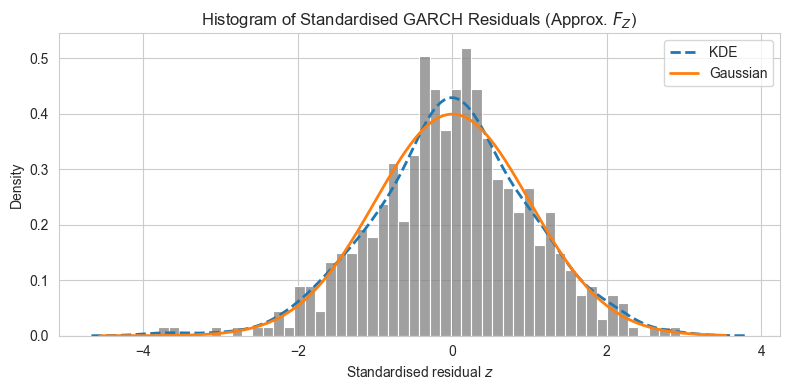

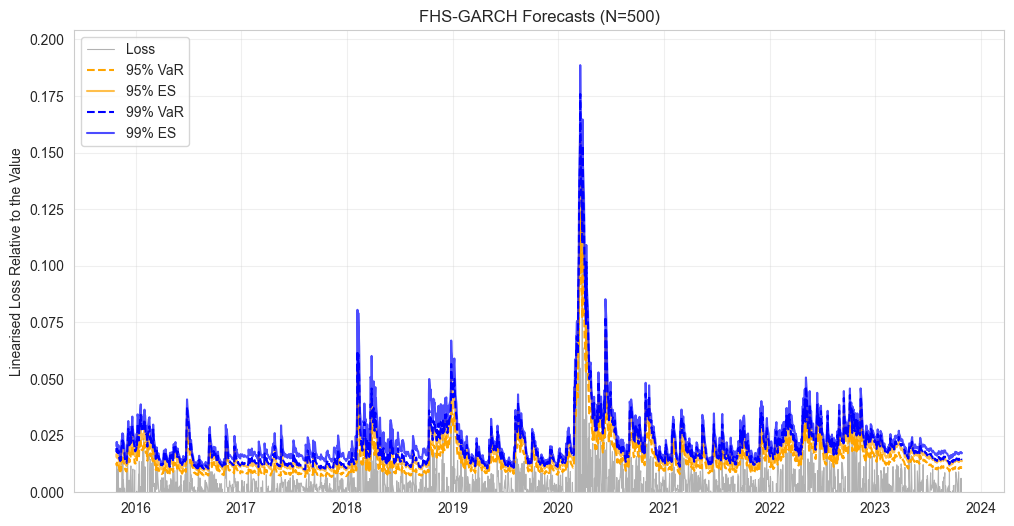

In [7]:
### Part (iii)
windows = sliding_window_view(losses[:-1], window_shape=N)
var_95_iii = np.zeros(T-N)
es_95_iii = np.zeros(T-N)
var_99_iii = np.zeros(T-N)
es_99_iii = np.zeros(T-N)
for i in range(T-N):
    am = arch_model(windows[i] * 100, mean='Constant', vol='Garch', p=1, q=1, dist='normal')
    res = am.fit(update_freq=0, disp='off')

    std_residuals = res.std_resid

    var_95_z_iii = np.quantile(std_residuals, 0.95)
    es_95_z_iii = std_residuals[std_residuals >= var_95_z_iii].mean()

    var_99_z_iii = np.quantile(std_residuals, 0.99)
    es_99_z_iii = std_residuals[std_residuals >= var_99_z_iii].mean()

    forecast = res.forecast(horizon=1)

    mu_forecast = forecast.mean.iloc[-1].values[0] / 100.0
    sigma_forecast = np.sqrt(forecast.variance.iloc[-1].values[0]) / 100.0

    var_95_iii[i] = mu_forecast + sigma_forecast * var_95_z_iii
    es_95_iii[i] = mu_forecast + sigma_forecast * es_95_z_iii

    var_99_iii[i] = mu_forecast + sigma_forecast * var_99_z_iii
    es_99_iii[i] = mu_forecast + sigma_forecast * es_99_z_iii

last_window = losses[-N:] * 100
am_last  = arch_model(last_window, mean='Constant', vol='Garch',
                      p=1, q=1, dist='normal')
res_last = am_last.fit(update_freq=0, disp='off')
z_last = res_last.std_resid

plt.figure(figsize=(8, 4))
sns.histplot(z_last, bins=50, stat="density",
             color="gray")
sns.kdeplot(z_last, color="#1f77b4", linestyle="--", linewidth=2,
            label="KDE")

x = np.linspace(z_last.min()*1.2, z_last.max()*1.2, 400)
plt.plot(x, norm.pdf(x), color="#ff7f0e", linewidth=2, label="Gaussian")

plt.title("Histogram of Standardised GARCH Residuals (Approx. $F_Z$)")
plt.xlabel("Standardised residual $z$")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(target_dates, targets, 'gray', alpha=0.6, lw=0.8, label='Loss')
plt.plot(target_dates, var_95_iii, 'orange', linestyle='--', label='95% VaR')
plt.plot(target_dates, es_95_iii, 'orange', alpha=0.7, label='95% ES')
plt.plot(target_dates, var_99_iii, 'blue', linestyle='--', label='99% VaR')
plt.plot(target_dates, es_99_iii, 'blue', alpha=0.7, label='99% ES')
plt.ylim(bottom=0) # Only include positive losses
plt.title(f'FHS-GARCH Forecasts (N={N})')
plt.ylabel('Linearised Loss Relative to the Value')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.savefig('assets/fhs_garch.png')
plt.show()


### Backtesting

In [8]:
### Backtesting
# Violations
v_95_i = targets > var_95_i
v_99_i = targets > var_99_i
v_95_ii = targets > var_95_ii
v_99_ii = targets > var_99_ii
v_95_iii = targets > var_95_iii
v_99_iii = targets > var_99_iii

def backtest(violations, alpha):

    T = len(violations)
    N1 = np.sum(violations)
    N0 = T - N1
    eps = 1e-15 # Prevent divide by zero

    # Unconditional Coverage
    pi = N1 / T

    logL_H0 = N0 * np.log(alpha) + N1 * np.log(1-alpha)
    logL_H1 = N0 * np.log(1 - pi) + N1 * np.log(pi)
    LR_uc = -2 * (logL_H0 - logL_H1)
    p_uc = 1 - chi2.cdf(LR_uc, 1)

    # Independence
    t00, t01, t10, t11 = 0, 0, 0, 0
    for i in range(1, T):
        if not violations[i-1] and not violations[i]: t00 += 1
        if not violations[i-1] and violations[i]: t01 += 1
        if violations[i-1] and not violations[i]: t10 += 1
        if violations[i-1] and violations[i]: t11 += 1

    pi01 = t01 / (t00 + t01)
    pi11 = t11 / (t10 + t11)

    logL_H0 = (t00 + t10) * np.log(1 - pi + eps) + (t01 + t11) * np.log(pi + eps)
    logL_H1 = t00 * np.log(1 - pi01 + eps) + t01 * np.log(pi01 + eps) + t10 * np.log(1 - pi11 + eps) + t11 * np.log(pi11 + eps)

    LR_ind = -2 * (logL_H0 - logL_H1)
    p_ind = 1 - chi2.cdf(LR_ind, 1)

    # Joint
    LR_cc = LR_uc + LR_ind
    p_cc = 1.0 - chi2.cdf(LR_cc, 2)

    return LR_uc, p_uc, LR_ind, p_ind, LR_cc, p_cc

models = [
    ('HS', '95%', v_95_i, 0.95),
    ('HS', '99%', v_99_i, 0.99),
    ('FHS-EWMA', '95%', v_95_ii, 0.95),
    ('FHS-EWMA', '99%', v_99_ii, 0.99),
    ('FHS-GARCH', '95%', v_95_iii, 0.95),
    ('FHS-GARCH', '99%', v_99_iii, 0.99),
]
results_uc = []
results_ind = []
results_cc = []
for name, alpha_str, violations, alpha_val in models:
    LR_uc, p_uc, LR_ind, p_ind, LR_cc, p_cc = backtest(violations, alpha_val)
    results_uc.append({
        'Model': name,
        'alpha': alpha_str,
        'LR_uc': LR_uc,
        'p_uc': p_uc
    })
    results_ind.append({
        'Model': name,
        'alpha': alpha_str,
        'LR_ind': LR_ind,
        'p_ind': p_ind
    })
    results_cc.append({
        'Model': name,
        'alpha': alpha_str,
        'LR_cc': LR_cc,
        'p_cc': p_cc
    })
df_results_uc = pd.DataFrame(results_uc)
df_results_ind = pd.DataFrame(results_ind)
df_results_cc = pd.DataFrame(results_cc)
print(df_results_uc.to_string(index=False))
print(df_results_ind.to_string(index=False))
print(df_results_cc.to_string(index=False))


    Model alpha    LR_uc     p_uc
       HS   95% 0.032174 0.857646
       HS   99% 4.228302 0.039755
 FHS-EWMA   95% 0.032174 0.857646
 FHS-EWMA   99% 0.389410 0.532610
FHS-GARCH   95% 0.000652 0.979621
FHS-GARCH   99% 3.456630 0.062999
    Model alpha   LR_ind    p_ind
       HS   95% 4.722207 0.029776
       HS   99% 3.055690 0.080455
 FHS-EWMA   95% 0.180671 0.670797
 FHS-EWMA   99% 0.531409 0.466015
FHS-GARCH   95% 2.612224 0.106043
FHS-GARCH   99% 0.847393 0.357291
    Model alpha    LR_cc     p_cc
       HS   95% 4.754381 0.092811
       HS   99% 7.283992 0.026200
 FHS-EWMA   95% 0.212845 0.899045
 FHS-EWMA   99% 0.920819 0.631025
FHS-GARCH   95% 2.612876 0.270783
FHS-GARCH   99% 4.304023 0.116250


The plain HS model fails the independence test at the 95% level and, more importantly, fails both the unconditional and conditional coverage tests at the 99% level. Hence, HS does not provide reliable tail risk forecasts, especially for extreme quantiles.

Both FHS-EWMA and FHS-GARCH pass all three tests at 95% and 99%. Among them, FHS-EWMA exhibits the highest p-values across the board, indicating no evidence against correct coverage or independence at conventional significance levels.

Therefore, from a back-testing perspective, I would recommend the FHS-EWMA approach to Bob. It delivers VaR forecasts with accurate unconditional coverage and no significant clustering of violations at both 95% and 99% confidence levels, while being simpler and more stable than the rolling GARCH specification. FHS-GARCH performs reasonably well and could be considered as an alternative, but the statistical evidence in favour of FHS-EWMA is slightly stronger, whereas the plain HS model should not be used for risk management, particularly at the 99% level.

In [9]:
#Function for backtest ES for different model
def es_backtest(loss, var, es):
    #Indicator function for whether the loss exceeding the VaR
    I = (loss > var).astype(float)
    # value of loss compared to ES forecast
    ex1 = (loss - es) * I
    sum_ex1  = np.sum(ex1)
    sum_ex2 = np.sum(ex1**2)
    #Standard normal test statistics
    Z = sum_ex1 / np.sqrt(sum_ex2)
    #  p-value
    p = 1 - norm.cdf(Z)
    return {'Test Statistics': Z,'p-value': p}

In [10]:
#Create a data frame for backtest ES result
ES_backtest = pd.DataFrame({"HS-ES-95": es_backtest(losses[500:],var_95_i,es_95_i),
                      "HS-ES-99": es_backtest(losses[500:],var_99_i,es_99_i),
                      "FHS-EWMA_ES-95": es_backtest(losses[500:],var_95_ii,es_95_ii),
                      "FHS-EWMA_ES-99": es_backtest(losses[500:],var_99_ii,es_99_ii),
                      "FHS-GARCH_ES-95": es_backtest(losses[500:],var_95_iii,es_95_iii),
                      "FHS-GARCH_ES-99": es_backtest(losses[500:],var_99_iii,es_99_iii)}).T
print(ES_backtest)

                 Test Statistics   p-value
HS-ES-95                1.124804  0.130336
HS-ES-99                1.779569  0.037573
FHS-EWMA_ES-95          0.245975  0.402851
FHS-EWMA_ES-99         -0.829894  0.796701
FHS-GARCH_ES-95         0.809147  0.209215
FHS-GARCH_ES-99        -0.309106  0.621380


In the ES_backtest tabel, the test statistics for HS model is 1.12 and 1.78 with p-value 0.130 and 0.0376 respectively, there is enough statistical evidence to say the HS model is underestimating the expected shortfall. For the FHS with EWMA method, the p-value for 95% and 99% ES are 0.403 and 0.797 respectively, the ES is a good estimate. Similarly, FHS with GARCH model has p-value 0.209 and 0.621 respectively which demonstrates a good ES estimation.